In [85]:
import pickle
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

In [133]:
from itertools import count
from math import log10

def edge2node(edge_context) :
    '''
    edge_list : str, like 'ENSG00000115415 ENSG00000138496_ENSG00000115415 ENSG00000168961_ENSG00000115415, underline as seperator
    '''
    edge_l = edge_context.split('_')
    node_l = set(list(map(lambda x : x.split(' ')[0],edge_l)) + list(map(lambda x : x.split(' ')[1],edge_l)))
    return list(node_l)

def construct_module_interaction_network(module_xl,sheet_name) :
    '''
    module_xl : pd.ExcelFile; contain functional module information
    sheet_list : list; which sheet will be used to construct network
    '''
    g = nx.Graph()
    node_dict = {}
    description_dict = {}
    node_description = {}
    df = module_xl.parse(sheet_name)
    for i in range(df.shape[0]):
        go = df.loc[i,'GOID']
        description_dict[go] = df.loc[i,'Description']
        edge = df.loc[i,'Edges']
        nodes = edge2node(edge)
        for n in nodes :
            node_dict[n] = go
            node_description[n] = description_dict[go]
            edge_list = [(x.split(' ')[0],x.split(' ')[1],{'GO' : go,'Condition' : sheet_name}) for x in edge.split('_')]
            g.add_edges_from(edge_list)
    nx.set_node_attributes(g,node_dict,name='GO')
    nx.set_node_attributes(g,node_description,name='Description')
    
    return g

def remove_edges_without_candidate_gene(g,candidate_genes,mode='union') :
    rm_list = []
    for gene1,gene2 in g.edges :
        if mode == 'union' :
            if gene1 not in candidate_genes and gene2 not in candidate_genes :
                rm_list.append((gene1,gene2))
        else :
            if gene1 not in candidate_genes or gene2 not in candidate_genes :
                rm_list.append((gene1,gene2))

    g.remove_edges_from(rm_list)
    #remoev node without any edge
    for node in list(g.nodes) :
        if g.degree[node] == 0 :
            g.remove_node(node)

def plot_gene_interaction_network(g,ens2hgsc,output_path,weight='Vote',degree_threshold=10,hue='GO',cmap=plt.cm.Set3,title="Gene interaction network",fig_size = (20,12)) :
    '''
    g : nx.Graph(); gene interaction network of candidate functional modules, node in graph have GO attribute.
    description_dict : dict; go to go description converter
    '''
    # get unique groups
    groups = set(nx.get_node_attributes(g,hue).values())
    mapping = dict(zip(sorted(groups),count()))
    nodes = g.nodes()
    colors = [mapping[g.nodes[n][hue]] for n in nodes]

    plt.figure(figsize=fig_size)
    pos = nx.kamada_kawai_layout(g)
    values = []
    for x in list(g.nodes) :
        if g.degree[x] == 0 :
            degree == 100
        else :
            degree = g.degree[x] * 100 
        if g.nodes[x][weight] == 0 :
            weighting = 1
        else :
            weighting = log10(g.nodes[x][weight])
        values.append(degree * weighting)

    labels = {}
    for key,val in g.degree() :
        if val > degree_threshold and key in pos:
            labels[key] = ens2hgsc[key] + "\n(vote=%d)" % g.nodes[key][weight]
        
    nx.draw_networkx_nodes(g, pos, cmap=cmap, node_size = values,node_color=colors)
    nx.draw_networkx_labels(g,pos, labels)
    nx.draw_networkx_edges(g, pos,alpha=0.2)
    
    for key,val in mapping.items():
        plt.scatter([],[], c=[cmap(val/(max(colors)+1))], label='{}'.format(key))
            
    plt.legend(bbox_to_anchor=(1,1))
    plt.title(title)
    plt.savefig(output_path,bbox_inches='tight',dpi=300)

In [72]:
with open("/home/bruce1996/data/LIHC_anomaly_detection/data/coding_gene_info/hgnc2ensembl.pkl",'rb') as f :
    hgsc2ens = pickle.load(f)
f.close()
ens2hgsc = {}
for hgsc,ens in hgsc2ens.items() :
    ens2hgsc[ens] = hgsc

### vote distribution

In [7]:
functional_module_path = '/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/'
condition = ['hbv_only_35','tumor_only_25']
ppi = 'PIN'
ppi_xl = pd.ExcelFile(functional_module_path + 'Summary_table_of_%s_FunModu.xlsx' % ppi)

module_network = {}
module_genes_dict = {}
for sheet in condition :
    df = ppi_xl.parse(sheet)
    g,description_dict = construct_module_interaction_network(ppi_xl,sheet)
    module_network[sheet] = g
    module_genes = []
    for idx in range(df.shape[0]) :
        nodes = df["Nodes"][idx].split("_")
        module_genes += nodes
    module_genes_dict[sheet] = list(set(module_genes))

In [8]:
survival_summary = pd.read_csv("cox_regression_summary_of_%s_module.txt" % ppi,sep='\t',index_col=0)
con = condition[1]
candidate_hgsc = survival_summary['Gene'][survival_summary['Condition'] == con].unique()
candidate_hgsc = [x.replace('.','-') if '.' in x else x for x in candidate_hgsc]
candidate_genes = [hgsc2ens[x] for x in candidate_hgsc]
remove_edges_without_candidate_gene(module_network[con],candidate_genes)

In [6]:
hbv_exp_m = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/hbv_only_coding_gene_std_by_gene_with_synthetic.txt",sep='\t',index_col=0)
hbv_vote_np = np.load("/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/with_synthetic/hbv_only_std_by_gene/hbv_only_std_by_gene__vote_np_ratio_35.npy")
hbv_vote = pd.Series(hbv_vote_np,index=hbv_exp_m.index)
tumor_exp_m = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/tumor_only_coding_gene_std_by_gene_with_synthetic.txt",sep='\t',index_col=0)
tumor_vote_np = np.load("/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/with_synthetic/tumor_only_std_by_gene/tumor_only_std_by_gene__vote_np_ratio_25.npy")
tumor_vote = pd.Series(tumor_vote_np,index=tumor_exp_m.index)
vote_df = pd.DataFrame({'HBV_vote' : hbv_vote,'Tumor_vote' : tumor_vote})
module_genes_vote_df = vote_df.loc[module_genes,:]
module_genes_vote_df["Condition"] = np.where([x in candidate_genes for x in module_genes_vote_df.index],"Survival_associated_genes",'Module_genes')

In [ ]:
from scipy.stats import ranksums
fig_output_path = "/home/bruce1996/data/LIHC_anomaly_detection/fig/survival_analysis/survival_vote_histogram/"
# hbv vote vs tumor vote
plt.figure(figsize=(8,5))
x1 = module_genes_vote_df.loc[candidate_genes,'HBV_vote'].values
x2 = module_genes_vote_df.loc[candidate_genes,'Tumor_vote'].values
res = ranksums(x1, x2)
plt.hist(x1, bins=20, alpha=0.5, label="HBV")
plt.hist(x2, bins=20, alpha=0.5, label="Tumor")
plt.xlabel("Vote", size=14)
plt.ylabel("Count", size=14)
plt.text(200,50,"Wilcoxon rank-sum p-value %0.6f" % res.pvalue)
plt.title("Vote distribution of %s survival-associated genes (%d genes)" % (ppi,len(candidate_genes)))
plt.legend(loc='upper right')
plt.savefig(fig_output_path + '%s_survival_associated_genes_hbv_tumor_difference.png' % ppi,dpi = 300)
# hbv vote difference between module genes & 
plt.figure(figsize=(8,5))
x1 = module_genes_vote_df.loc[candidate_genes,'HBV_vote'].values
x2 = module_genes_vote_df.loc[set(module_genes) - set(candidate_genes),'HBV_vote'].values
res = ranksums(x1, x2)
plt.hist(x1, bins=20, alpha=0.5, label="Survival-associated genes (%d genes)" % len(candidate_genes))
plt.hist(x2, bins=20, alpha=0.5, label="Module genes (%d genes)" % len(set(module_genes) - set(candidate_genes)))
plt.xlabel("Vote", size=14)
plt.ylabel("Count", size=14)
plt.text(200,50,"Wilcoxon rank-sum p-value %0.6f" % res.pvalue)
plt.title("%s vote distribution of %s module genes" % ("HBV",ppi))
plt.legend(loc='upper right')
plt.savefig(fig_output_path + '%s_modules_genes_hbv_histogram.png' % ppi,dpi = 300)
# hbv vote difference between module genes & 
plt.figure(figsize=(8,5))
x1 = module_genes_vote_df.loc[candidate_genes,'Tumor_vote'].values
x2 = module_genes_vote_df.loc[set(module_genes) - set(candidate_genes),'Tumor_vote'].values
res = ranksums(x1, x2)
plt.hist(x1, bins=20, alpha=0.5, label="Survival-associated genes (%d genes)" % len(candidate_genes))
plt.hist(x2, bins=20, alpha=0.5, label="Module genes (%d genes)" % len(set(module_genes) - set(candidate_genes)))
plt.xlabel("Vote", size=14)
plt.ylabel("Count", size=14)
plt.text(200,30,"Wilcoxon rank-sum p-value %0.6f" % res.pvalue)
plt.title("%s vote distribution of %s module genes" % ("Tumor",ppi))
plt.legend(loc='upper right')
plt.savefig(fig_output_path + '%s_modules_genes_tumor_histogram.png' % ppi,dpi = 300)


### interaction network

In [73]:
def module_interaction_network(g,module_genes,candidate_genes,vote,module_name=None) :
    """_summary_

    Args:
        g (networkx graph): gene interaction network
        description_dict (dict): go accession to go description
        module_genes (list/np_array): Gene list in functional module which have edge in gene interaction network
        candidate_genes (list/np_array): candidate in module genes
        vote (pd.Series): record module gene vote number
    """    
    G = g.copy()
    vote_dict = dict(zip(list(vote.index),vote.values))
    condition = ["Survival-associated gene" if x in candidate_genes else "Module gene" for x in module_genes]
    condition_dict = dict(zip(module_genes,condition))
    nx.set_node_attributes(G,vote_dict,name='Vote')
    nx.set_node_attributes(G,condition_dict,name='Condition')
    if module_name :
        for node in G.nodes :
            G.nodes[node]['GO'] = module_name

    return G
    

In [74]:
functional_module_path = '/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/'
condition = ['hbv_only_35','tumor_only_25']
ppi = 'PIN'
ppi_xl = pd.ExcelFile(functional_module_path + 'Summary_table_of_%s_FunModu.xlsx' % ppi)
survival_summary = pd.read_csv("cox_regression_summary_of_%s_module.txt" % ppi,sep='\t',index_col=0)

module_network = {}
module_genes_dict = {}
vote_dict = {}
go_description = {}
for sheet in condition :
    df = ppi_xl.parse(sheet)
    g = construct_module_interaction_network(ppi_xl,sheet)
    module_network[sheet] = g
    module_genes = []
    for idx in range(df.shape[0]) :
        nodes = df["Nodes"][idx].split("_")
        module_genes += nodes
    module_genes_dict[sheet] = list(set(module_genes))
    #load vote
    exp_m = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/%s_coding_gene_std_by_gene_with_synthetic.txt" % sheet[:-3],sep='\t',index_col=0)
    vote_np = np.load("/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/with_synthetic/%s_std_by_gene/%s_std_by_gene__vote_np_ratio_35.npy" % (sheet[:-3],sheet[:-3]))
    vote_dict[sheet] = pd.Series(vote_np,index=exp_m.index)

In [ ]:
fig_survival_path = "/home/bruce1996/data/LIHC_anomaly_detection/fig/survival_analysis/survival_interaction_network/%s_%s_survival_associated_gene_interaction_network.png" % (ppi,sheet)
fig_module_path = "/home/bruce1996/data/LIHC_anomaly_detection/fig/survival_analysis/survival_interaction_network/%s_%s_module_gene_interaction_network.png" % (ppi,sheet)

if con == 'hbv_only_35' :
    remove_edges_without_candidate_gene(g,candidate_genes,mode='union')
    plot_gene_interaction_network(g,description_dict,ens2hgsc,output_path=fig_path,weight='HBV_vote',degree_threshold=3,fig_size=(20,12))
else :
    remove_edges_without_candidate_gene(g,candidate_genes,mode='inter')
    plot_gene_interaction_network(g,description_dict,ens2hgsc,output_path=fig_path,weight='Tumor_vote',degree_threshold=3,fig_size=(20,12))

In [ ]:
for ppi in ['GRN',"PIN"] :

    functional_module_path = '/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/'
    condition = ['hbv_only_35','tumor_only_25']
    ppi_xl = pd.ExcelFile(functional_module_path + 'Summary_table_of_%s_FunModu.xlsx' % ppi)
    survival_summary = pd.read_csv("cox_regression_summary_of_%s_module.txt" % ppi,sep='\t',index_col=0)

    module_network = {}
    module_genes_dict = {}
    vote_dict = {}
    go_description = {}
    for sheet in condition :
        df = ppi_xl.parse(sheet)
        g,description_dict = construct_module_interaction_network(ppi_xl,sheet)
        module_network[sheet] = g
        module_genes = []
        for idx in range(df.shape[0]) :
            nodes = df["Nodes"][idx].split("_")
            module_genes += nodes
        module_genes_dict[sheet] = list(set(module_genes))
        for key,val in description_dict.items() :
            go_description[key] = val
        #load vote
        exp_m = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/%s_coding_gene_std_by_gene_with_synthetic.txt" % sheet[:-3],sep='\t',index_col=0)
        vote_np = np.load("/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/with_synthetic/%s_std_by_gene/%s_std_by_gene__vote_np_ratio_35.npy" % (sheet[:-3],sheet[:-3]))
        vote_dict[sheet] = pd.Series(vote_np,index=exp_m.index)

    for sheet in ['hbv_only_35','tumor_only_25'] :
        
        survival_summary = pd.read_csv("cox_regression_summary_of_%s_module.txt" % ppi,sep='\t',index_col=0)
        candidate_hgsc = survival_summary['Gene'][survival_summary['Condition'] == sheet].unique()
        candidate_hgsc = [x.replace('.','-') if '.' in x else x for x in candidate_hgsc]
        candidate_genes = [hgsc2ens[x] for x in candidate_hgsc]
        module_g = module_interaction_network(module_network[sheet],module_genes_dict[sheet],candidate_genes,vote_dict[sheet])
        survival_g = module_g.copy()
        if sheet == 'hbv_only_35' :
            remove_edges_without_candidate_gene(survival_g,candidate_genes)
        else :
            remove_edges_without_candidate_gene(survival_g,candidate_genes,mode='inter')

        #plot interaction network
        fig_module_path = "/home/bruce1996/data/LIHC_anomaly_detection/fig/survival_analysis/survival_interaction_network/%s_%s_module_gene_interaction_network.png" % (ppi,sheet[:-3])
        fig_survival_path = "/home/bruce1996/data/LIHC_anomaly_detection/fig/survival_analysis/survival_interaction_network/%s_%s_survival_associated_gene_interaction_network.png" % (ppi,sheet[:-3])

        plot_gene_interaction_network(module_g,go_description,ens2hgsc,output_path=fig_module_path,hue='Condition',degree_threshold=0,fig_size=(20,12))
        plot_gene_interaction_network(survival_g,go_description,ens2hgsc,output_path=fig_survival_path,hue='GO',degree_threshold=0,fig_size=(20,12))

### Module vote boxplot

In [ ]:
module_vote = pd.DataFrame()

for sheet in ['hbv_only_35','tumor_only_25'] :
    df = ppi_xl.parse(sheet)
    exp_m = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/%s_coding_gene_std_by_gene_with_synthetic.txt" % sheet[:-3],sep='\t',index_col=0)
    vote_np = np.load("/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/with_synthetic/%s_std_by_gene/%s_std_by_gene__vote_np_ratio_35.npy" % (sheet[:-3],sheet[:-3]))
    vote_series = pd.Series(vote_np,index=exp_m.index)

    for idx in range(df.shape[0]) :
        nodes = df["Nodes"][idx].split("_")
        vote = vote_series[nodes].values
        des = [df["Description"][idx]] * len(nodes)
        tmp = pd.DataFrame({'Description' : des,'Gene' : nodes,'Vote' : vote})
        module_vote = pd.concat([module_vote,tmp])

    plt.figure(figsize=(12,4))
    sns.boxplot(data=module_vote,x='Description',y='Vote',palette="Set3",order=module_vote.groupby('Description').agg('median').sort_values(by='Vote',ascending=False).index)
    plt.xticks(rotation=90)
    plt.title("%s functional module %s vote distribution" % (ppi,'HBV'))
    plt.legend([], [], frameon=False)
    fig_output_path = "/home/bruce1996/data/LIHC_anomaly_detection/fig/survival_analysis/survival_vote_histogram/%s_module_%s_vote_boxplot.png" % (ppi,'hbv')
    plt.savefig(fig_output_path,dpi=300,bbox_inches='tight')

hbv_only_35 cellular response to interferon-gamma
hbv_only_35 negative regulation of innate immune response
hbv_only_35 cellular response to cytokine stimulus
tumor_only_25 interleukin-27-mediated signaling pathway
tumor_only_25 response to interferon-beta
tumor_only_25 cellular response to cytokine stimulus


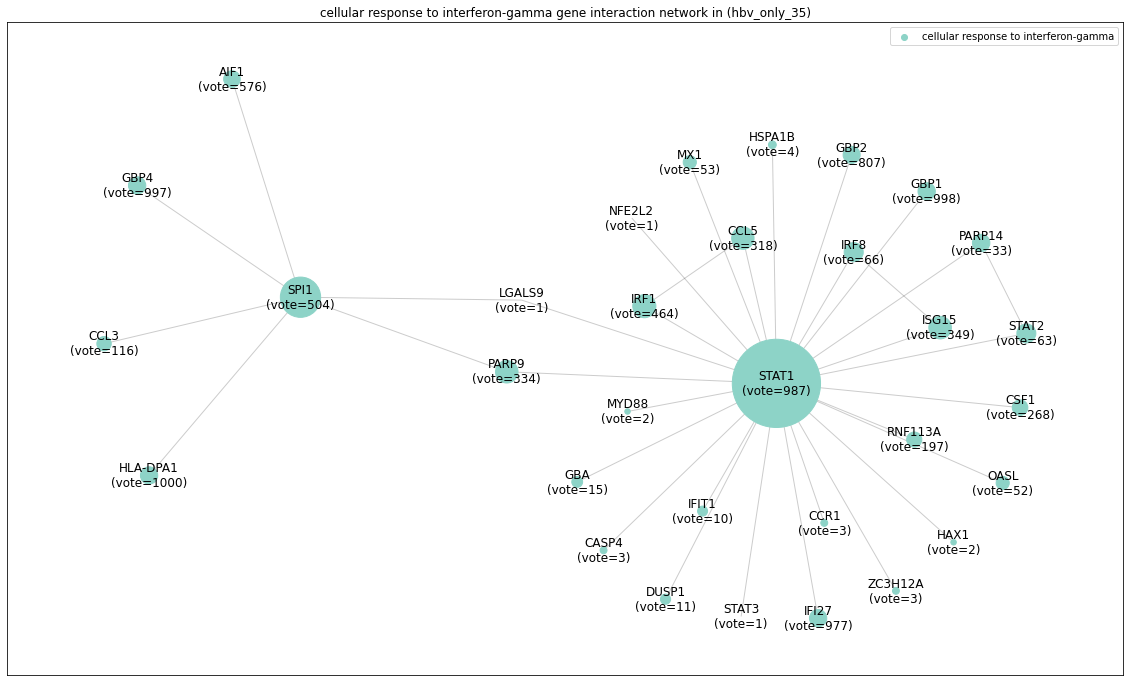

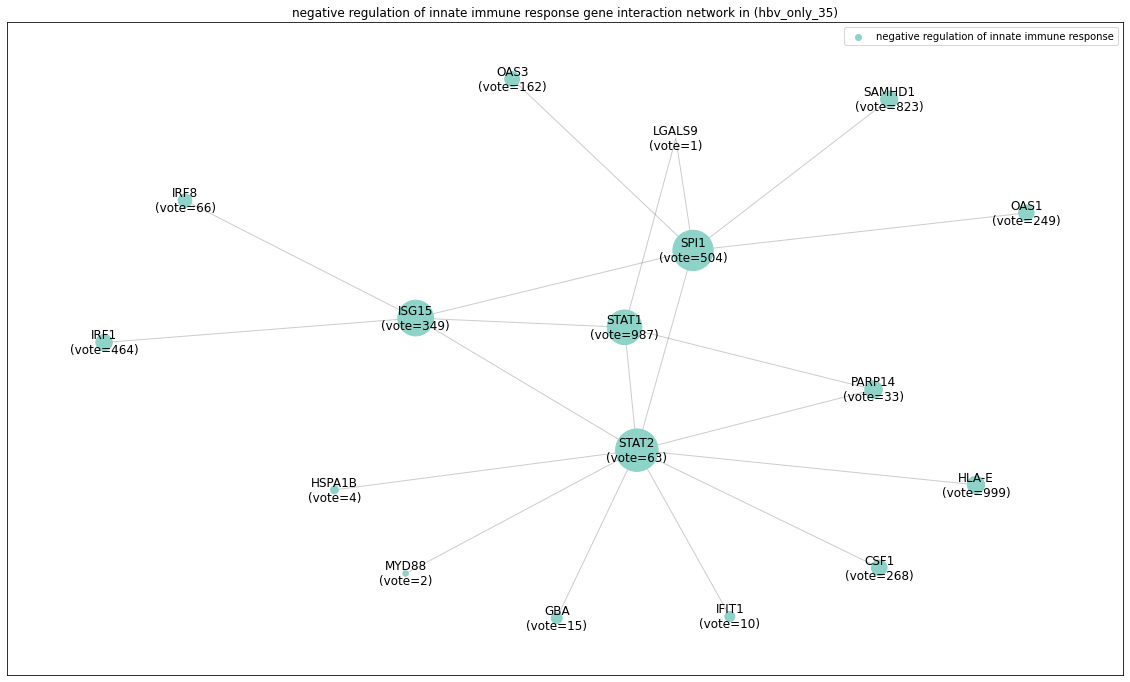

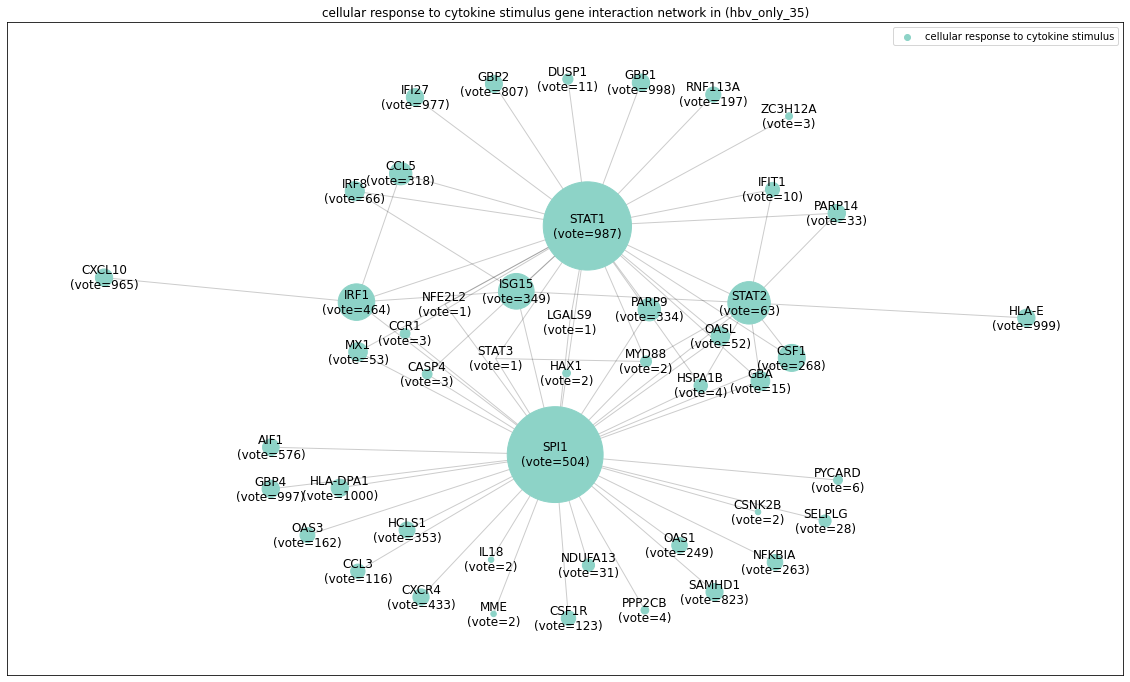

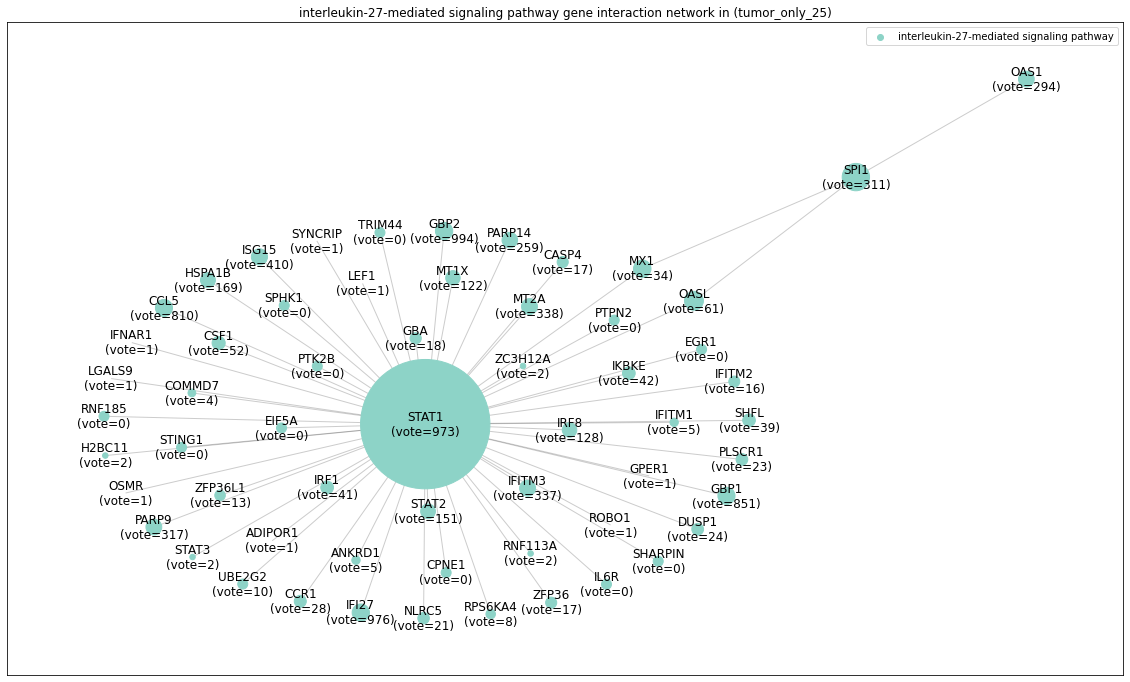

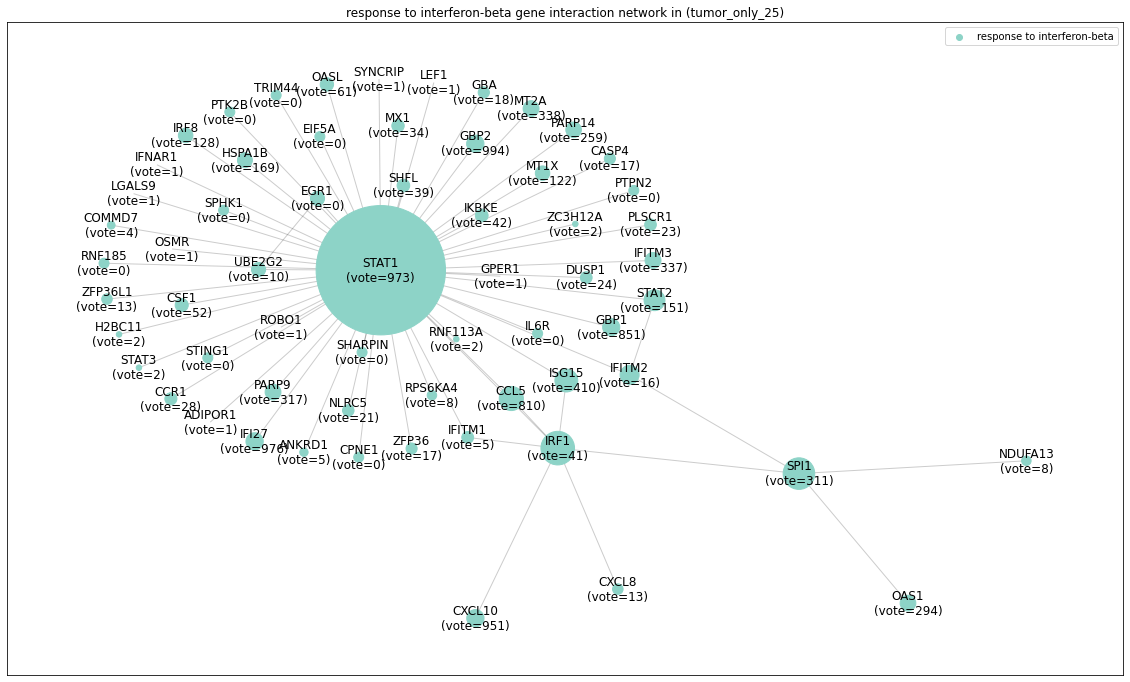

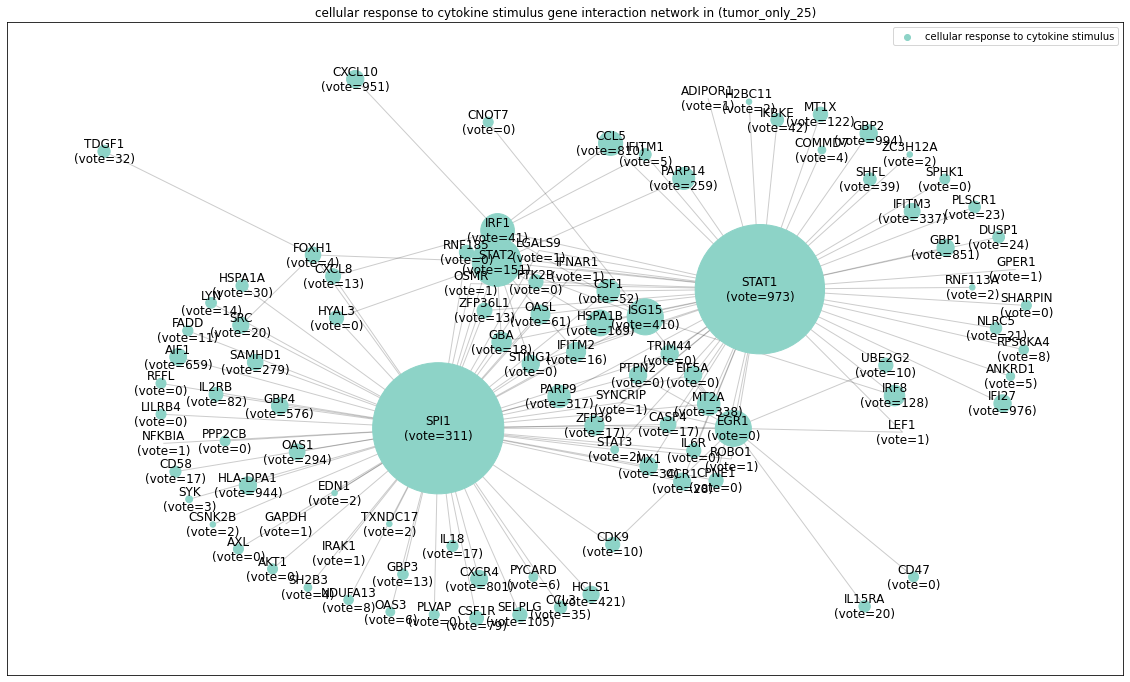

In [147]:
functional_module_path = '/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/'
condition = ['hbv_only_35','tumor_only_25']
ppi = 'GRN'
ppi_xl = pd.ExcelFile(functional_module_path + 'Summary_table_of_%s_FunModu.xlsx' % ppi)
survival_summary = pd.read_csv("cox_regression_summary_of_%s_module.txt" % ppi,sep='\t',index_col=0)

module_network = {}
module_genes_dict = {}
vote_dict = {}
go_description = {}
for sheet in condition :
    df = ppi_xl.parse(sheet)
    g = construct_module_interaction_network(ppi_xl,sheet)
    module_network[sheet] = g
    module_genes = []
    for idx in range(df.shape[0]) :
        nodes = df["Nodes"][idx].split("_")
        module_genes += nodes
    module_genes_dict[sheet] = list(set(module_genes))
    #load vote
    exp_m = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/ensemble_training/%s_coding_gene_std_by_gene_with_synthetic.txt" % sheet[:-3],sep='\t',index_col=0)
    vote_np = np.load("/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/with_synthetic/%s_std_by_gene/%s_std_by_gene__vote_np_ratio_35.npy" % (sheet[:-3],sheet[:-3]))
    vote_dict[sheet] = pd.Series(vote_np,index=exp_m.index)

for sheet in condition :
    
    survival_summary = pd.read_csv("cox_regression_summary_of_%s_module.txt" % ppi,sep='\t',index_col=0)
    candidate_hgsc = survival_summary['Gene'][survival_summary['Condition'] == sheet].unique()
    candidate_hgsc = [x.replace('.','-') if '.' in x else x for x in candidate_hgsc]
    candidate_genes = [hgsc2ens[x] for x in candidate_hgsc]
    module_g = module_interaction_network(module_network[sheet],module_genes_dict[sheet],candidate_genes,vote_dict[sheet])
    # statistic for module vote 
    df = ppi_xl.parse(sheet)
    module_vote = pd.DataFrame()
    for idx in range(df.shape[0]) :
        nodes = df["Nodes"][idx].split("_")
        vote = vote_dict[sheet][nodes].values
        des = [df["Description"][idx]] * len(nodes)
        tmp = pd.DataFrame({'Description' : des,'Gene' : nodes,'Vote' : vote})
        module_vote = pd.concat([module_vote,tmp])
    n_modules = len(module_vote['Description'].unique())
    vote_order = module_vote.groupby('Description').agg('median').sort_values(by='Vote',ascending=False)
    if ppi == 'GRN' :
        top_n_go = vote_order.index
    else :
        top_n_go = vote_order.index[:(n_modules // 5)]
        
    for go in top_n_go :
        print(sheet,go)
        go_g = module_g.copy()
        nodes = df["Nodes"][df['Description'] == go].values[0].split("_")
        remove_edges_without_candidate_gene(go_g,nodes)
        for node in go_g.nodes :
            go_g.nodes[node]['Description'] = go
        fig_go_path = "/home/bruce1996/data/LIHC_anomaly_detection/fig/survival_analysis/survival_interaction_network/%s_%s_%s_gene_interaction_network.png" % (ppi,sheet[:-3],go.replace(" ","-"))
        plot_gene_interaction_network(go_g,ens2hgsc,title="%s gene interaction network in (%s)" % (go,sheet),output_path=fig_go_path,hue='Description',weight='Vote',degree_threshold=0,fig_size=(20,12))
